In [1]:
import tensorflow as tf
import numpy as np
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

path_ai = '/content/drive/MyDrive/ds340/ai_images'
print(f"Contents of {path_ai}:")
print(os.listdir(path_ai))  # This should list your AI images


Contents of /content/drive/MyDrive/ds340/ai_images:
['6-234077831-733567.jpg', '6-234246248-91184.jpg', '6-234417221-62825.jpg', '6-236710992-255071.jpg', '6-237822277-478212_ai.jpg']


In [3]:


# Your special processing method
def smash_n_reconstruct(filepath):
    # Actual logic to read and process the image
    # Replace with your real image processing logic
    rich_texture = np.random.rand(256, 256).astype(np.float32)  # Mock data for rich texture
    poor_texture = np.random.rand(256, 256).astype(np.float32)  # Mock data for poor texture
    return rich_texture, poor_texture

def preprocess(filepath):
    # Load the image using the special processing method
    rich_texture, poor_texture = smash_n_reconstruct(filepath)

    # Ensure the outputs are grayscale images of shape (256, 256, 1)
    rich_texture = np.expand_dims(rich_texture, axis=-1)  # Shape: (256, 256, 1)
    poor_texture = np.expand_dims(poor_texture, axis=-1)  # Shape: (256, 256, 1)

    # Convert to tf.float32 for TensorFlow
    rich_texture = tf.convert_to_tensor(rich_texture, dtype=tf.float32)
    poor_texture = tf.convert_to_tensor(poor_texture, dtype=tf.float32)

    return rich_texture, poor_texture

# Load your image paths and labels
path_ai = '/content/drive/MyDrive/ds340/ai_images'
path_real = '/content/drive/MyDrive/ds340/real_images'

# Load AI images
ai_imgs = [os.path.join(path_ai, img) for img in os.listdir(path_ai)]
ai_labels = [1] * len(ai_imgs)  # 1 for AI-generated images

# Load real images
real_imgs = [os.path.join(path_real, img) for img in os.listdir(path_real)]
real_labels = [0] * len(real_imgs)  # 0 for real images

# Combine image paths and labels
X_train = ai_imgs + real_imgs
y_train = ai_labels + real_labels

# Shuffle the dataset
combined = list(zip(X_train, y_train))
np.random.shuffle(combined)
X_train[:], y_train[:] = zip(*combined)

# Preprocess all images
X_processed = []
for filepath in X_train:
    rich_texture, poor_texture = preprocess(filepath)
    # Only appending rich textures for the training set
    X_processed.append(rich_texture.numpy())  # Convert tensor to numpy array for the dataset

# Convert to numpy array and check the shape
X_processed = np.array(X_processed)

# Check the shape of processed data
print(f"Processed training data shape: {X_processed.shape}")  # Expecting (num_samples, 256, 256, 1)

# Convert labels to numpy array
y_train = np.array(y_train)

# Define a simple CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(256, 256, 1)),  # Input shape for grayscale images
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Fit the model
model.fit(X_processed, y_train, epochs=5, batch_size=2, validation_split=0.2)

model_save_path = '/content/drive/MyDrive/ds340/checkpoints/my_model.keras'

# Create the directory in Google Drive if it doesn't exist
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

# Save the model
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

Processed training data shape: (10, 256, 256, 1)
Epoch 1/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 826ms/step - accuracy: 0.6000 - loss: 7.1847 - val_accuracy: 0.5000 - val_loss: 0.7564
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 922ms/step - accuracy: 0.2167 - loss: 0.9091 - val_accuracy: 0.5000 - val_loss: 0.6961
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 693ms/step - accuracy: 0.6500 - loss: 0.8058 - val_accuracy: 0.5000 - val_loss: 0.6941
Epoch 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 679ms/step - accuracy: 0.6500 - loss: 0.6728 - val_accuracy: 0.5000 - val_loss: 0.6966
Epoch 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 564ms/step - accuracy: 0.7333 - loss: 0.6904 - val_accuracy: 0.5000 - val_loss: 0.7029
Model saved to /content/drive/MyDrive/ds340/checkpoints/my_model.keras


In [4]:
!ls /content/drive/MyDrive/ds340/

ai_images  checkpoints	evaluate  preprocessing  real_images


In [5]:
import numpy as np
import tensorflow as tf
import shap
from tensorflow.keras.models import load_model
import sys

# Add path to preprocessing module if it is on Google Drive
sys.path.append('/content/drive/MyDrive/ds340/')

# Now import the module
from preprocessing.patch_generator import smash_n_reconstruct  # Using your existing texture analysis
import matplotlib.pyplot as plt
import os

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

def prepare_background_data(num_samples=10):
    """
    Prepare background data for SHAP analysis using both AI and real images.
    """
    background_data = []

    # Add paths to some representative background images
    background_paths = [
        '/content/drive/MyDrive/ds340/evaluate/7-103192408-508471_ai_2.jpg',
        # ... add more paths here
    ]

    for path in background_paths[:num_samples]:
        rich_texture, _ = smash_n_reconstruct(path, coloured=False)
        rich_texture = rich_texture.astype(np.float32) / 255.0  # Normalize to [0,1]
        if rich_texture.shape != (256, 256, 1):
            rich_texture = np.reshape(rich_texture, (256, 256, 1))
        background_data.append(rich_texture)

    return np.stack(background_data)

def preprocess_single_image(image_path):
    """Preprocess a single image for prediction and SHAP analysis."""
    rich_texture, _ = smash_n_reconstruct(image_path, coloured=False)
    rich_texture = rich_texture.astype(np.float32) / 255.0  # Normalize to [0,1]
    if rich_texture.shape != (256, 256, 1):
        rich_texture = np.reshape(rich_texture, (256, 256, 1))

    return np.expand_dims(rich_texture, axis=0)  # Add batch dimension

def explain_prediction(model_path, image_path, num_background_samples=10):
    """Generate and visualize SHAP explanations for a single image prediction."""
    model = load_model(model_path)
    test_image = preprocess_single_image(image_path)
    print(f"Test image shape: {test_image.shape}")

    background_data = prepare_background_data(num_background_samples)
    print(f"Background data shape: {background_data.shape}")

    explainer = shap.DeepExplainer(model, background_data)
    shap_values = explainer.shap_values(test_image)

    if isinstance(shap_values, list):
        shap_values = shap_values[0]

    abs_shap_values = np.abs(shap_values)
    max_value = np.percentile(abs_shap_values, 99)

    plt.figure(figsize=(10, 10))

    plt.subplot(2, 2, 1)
    plt.title('Original Image')
    plt.imshow(test_image[0, :, :, 0], cmap='gray')
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.title('SHAP Values')
    plt.imshow(shap_values[0, :, :, 0], cmap='RdBu', vmin=-max_value, vmax=max_value)
    plt.colorbar()
    plt.axis('off')

    plt.subplot(2, 2, 3)
    plt.title('Absolute SHAP Values')
    plt.imshow(abs_shap_values[0, :, :, 0], cmap='hot', vmax=max_value)
    plt.colorbar()
    plt.axis('off')

    plt.tight_layout()
    plt.savefig('/content/shap_explanation_3.png')
    plt.close()

    prediction = model.predict(test_image)[0][0]
    return shap_values, prediction

if __name__ == "__main__":
    # Set paths to Google Drive locations
    MODEL_PATH = '/content/drive/MyDrive/ds340/checkpoints/my_model.keras'
    TEST_IMAGE_PATH = '/content/drive/MyDrive/ds340/evaluate/7-103192408-508471_ai_2.jpg'

    shap_values, prediction = explain_prediction(
        model_path=MODEL_PATH,
        image_path=TEST_IMAGE_PATH,
        num_background_samples=10
    )

    print(f"Prediction: {prediction:.3f}")
    print(f"SHAP values shape: {shap_values.shape}")
    print("Explanation has been saved as 'shap_explanation_3.png'")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Generated 64 grayscale patches and 64 color patches.
Rich Texture Shape: (256, 256, 1), Poor Texture Shape: (256, 256, 1)
Test image shape: (1, 256, 256, 1)
Generated 64 grayscale patches and 64 color patches.
Rich Texture Shape: (256, 256, 1), Poor Texture Shape: (256, 256, 1)
Background data shape: (1, 256, 256, 1)


/usr/local/lib/python3.10/dist-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
Prediction: 0.497
SHAP values shape: (1, 256, 256, 1, 1)
Explanation has been saved as 'shap_explanation_3.png'


In [6]:
import numpy as np
import tensorflow as tf
import shap
from tensorflow.keras.models import load_model
import sys
import matplotlib.pyplot as plt
import os

# Add path to preprocessing module if it is on Google Drive
sys.path.append('/content/drive/MyDrive/ds340/')
from preprocessing.patch_generator import smash_n_reconstruct  # Using your existing texture analysis

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

def prepare_background_data(num_samples=10):
    """
    Prepare background data for SHAP analysis using both AI and real images.
    """
    background_data = []

    background_paths = [
        '/content/drive/MyDrive/ds340/evaluate/7-103192408-508471_ai_2.jpg',
        # Add more paths if needed
    ]

    for path in background_paths[:num_samples]:
        rich_texture, _ = smash_n_reconstruct(path, coloured=False)
        rich_texture = rich_texture.astype(np.float32) / 255.0  # Normalize to [0,1]
        if rich_texture.shape != (256, 256, 1):
            rich_texture = np.reshape(rich_texture, (256, 256, 1))
        background_data.append(rich_texture)

    return np.stack(background_data)

def preprocess_single_image(image_path):
    """Preprocess a single image for prediction and SHAP analysis."""
    rich_texture, _ = smash_n_reconstruct(image_path, coloured=False)
    rich_texture = rich_texture.astype(np.float32) / 255.0  # Normalize to [0,1]
    if rich_texture.shape != (256, 256, 1):
        rich_texture = np.reshape(rich_texture, (256, 256, 1))

    return np.expand_dims(rich_texture, axis=0)  # Add batch dimension

def overlay_shap_on_image(image, shap_values, alpha=0.5):
    """
    Overlay SHAP values on the original image.
    """
    overlay = np.squeeze(shap_values)  # Remove unnecessary dimensions
    normalized_overlay = (overlay - overlay.min()) / (overlay.max() - overlay.min())  # Normalize to [0,1]

    reconstructed_image = np.squeeze(image)  # Convert to 2D if necessary
    plt.imshow(reconstructed_image, cmap='gray', alpha=1)  # Base image in grayscale
    plt.imshow(normalized_overlay, cmap='RdBu', alpha=alpha, vmin=0, vmax=1)  # SHAP overlay
    plt.axis('off')
    plt.title('Reconstructed Image with SHAP Overlay')

def explain_with_shapv2(model_path, image_path, num_background_samples=10):
    """Generate and visualize SHAP explanations, including a reconstructed image with SHAP values."""
    # Load the trained model
    model = load_model(model_path)

    # Preprocess the input image
    test_image = preprocess_single_image(image_path)
    print(f"Test image shape: {test_image.shape}")

    # Prepare background data
    background_data = prepare_background_data(num_background_samples)
    print(f"Background data shape: {background_data.shape}")

    # Create SHAP explainer and compute SHAP values
    explainer = shap.DeepExplainer(model, background_data)
    shap_values = explainer.shap_values(test_image)

    if isinstance(shap_values, list):
        shap_values = shap_values[0]

    abs_shap_values = np.abs(shap_values)
    max_value = np.percentile(abs_shap_values, 99)

    # Create visualizations
    plt.figure(figsize=(12, 12))

    # Original Image
    plt.subplot(2, 2, 1)
    plt.title('Original Image')
    plt.imshow(test_image[0, :, :, 0], cmap='gray')
    plt.axis('off')

    # SHAP Values
    plt.subplot(2, 2, 2)
    plt.title('SHAP Values')
    plt.imshow(shap_values[0, :, :, 0], cmap='RdBu', vmin=-max_value, vmax=max_value)
    plt.colorbar()
    plt.axis('off')

    # Absolute SHAP Values
    plt.subplot(2, 2, 3)
    plt.title('Absolute SHAP Values')
    plt.imshow(abs_shap_values[0, :, :, 0], cmap='hot', vmax=max_value)
    plt.colorbar()
    plt.axis('off')

    # Reconstructed Image with SHAP Overlay
    plt.subplot(2, 2, 4)
    overlay_shap_on_image(test_image[0], shap_values[0])

    # Save the visualizations
    plt.tight_layout()
    plt.savefig('/content/shap_explanation_v2.png')
    plt.close()
    print("Explanation with overlay saved as 'shap_explanation_v2.png'.")

    # Make a prediction and return SHAP values and prediction
    prediction = model.predict(test_image)[0][0]
    return shap_values, prediction

if __name__ == "__main__":
    # Set paths to Google Drive locations
    MODEL_PATH = '/content/drive/MyDrive/ds340/checkpoints/my_model.keras'
    TEST_IMAGE_PATH = '/content/drive/MyDrive/ds340/evaluate/7-103192408-508471_ai_2.jpg'

    # Generate explanations and display the prediction
    shap_values, prediction = explain_with_shapv2(
        model_path=MODEL_PATH,
        image_path=TEST_IMAGE_PATH,
        num_background_samples=10
    )

    print(f"Prediction: {prediction:.3f}")
    print(f"SHAP values shape: {shap_values.shape}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Generated 64 grayscale patches and 64 color patches.
Rich Texture Shape: (256, 256, 1), Poor Texture Shape: (256, 256, 1)
Test image shape: (1, 256, 256, 1)
Generated 64 grayscale patches and 64 color patches.
Rich Texture Shape: (256, 256, 1), Poor Texture Shape: (256, 256, 1)
Background data shape: (1, 256, 256, 1)
Explanation with overlay saved as 'shap_explanation_v2.png'.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
Prediction: 0.497
SHAP values shape: (1, 256, 256, 1, 1)


Generated 64 grayscale patches and 64 color patches.
Rich Texture Shape: (256, 256, 1), Poor Texture Shape: (256, 256, 1)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

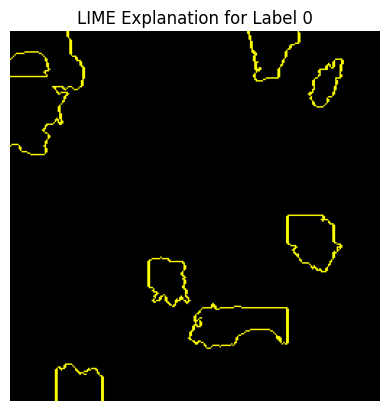

In [10]:
# Adding LIME for image model interpretability

# Install LIME if not already installed
!pip install lime

from lime import lime_image
from skimage.segmentation import mark_boundaries
import numpy as np
import matplotlib.pyplot as plt

# Initialize the LimeImageExplainer
explainer = lime_image.LimeImageExplainer()

# Example: Choose a sample image to explain
sample_index = 0  # Change to the index of the image you want to explain
image_path = X_train[sample_index]

# Preprocess the image for the model (adapt this to your preprocessing steps)
rich_texture, _ = preprocess(image_path)  # Replace this with your real preprocessing function

# Ensure the input image has the correct shape
image_to_explain = rich_texture.numpy()  # Convert to numpy
if image_to_explain.shape[-1] == 1:  # If grayscale, expand to 3 channels for LIME
    image_to_explain = np.repeat(image_to_explain, 3, axis=-1)

# Define a wrapper function for the model prediction
def model_predict_wrapper(images):
    # Convert RGB images back to grayscale and add batch and channel dimensions
    images_gray = np.mean(images, axis=-1, keepdims=True)  # Convert RGB to grayscale
    return model.predict(images_gray)

# Get explanation for the image
explanation = explainer.explain_instance(
    image=image_to_explain.squeeze(),  # Input image
    classifier_fn=model_predict_wrapper,  # Wrapped predict function
    top_labels=2,
    hide_color=0,
    num_samples=1000  # Number of perturbations
)

# Dynamically select the label to visualize
label_to_visualize = explanation.top_labels[0]  # Select the top predicted label

# Visualize the explanation
temp, mask = explanation.get_image_and_mask(
    label=label_to_visualize,  # Dynamically select the label
    positive_only=True,
    num_features=10,
    hide_rest=False
)

# Display the image with explanations
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title(f"LIME Explanation for Label {label_to_visualize}")
plt.axis("off")
plt.show()
